In [1]:
# # this just to make sure we are using only on CPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
%matplotlib nbagg
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

from fastmri_recon.data.fastmri_sequences import Masked2DSequence
from fastmri_recon.helpers.nn_mri import lrelu
from fastmri_recon.models.cascading import cascade_net
from fastmri_recon.models.pdnet import pdnet
from fastmri_recon.models.kiki import kiki_net

/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In [4]:
# paths
train_path = '/media/Zaccharie/UHRes/singlecoil_train/singlecoil_train/'
val_path = '/media/Zaccharie/UHRes/singlecoil_val/'
test_path = '/media/Zaccharie/UHRes/singlecoil_test/'

n_samples_train = 34742
n_samples_val = 7135

n_volumes_train = 973
n_volumes_val = 199


# generators
AF = 4
train_gen = Masked2DSequence(train_path, af=AF, inner_slices=8, rand=True, scale_factor=1e6)
val_gen = Masked2DSequence(val_path, af=AF, scale_factor=1e6)

In [5]:
# #pdnet
# run_params = {
#     'n_primal': 5,
#     'n_dual': 5,
#     'n_iter': 10,
#     'n_filters': 32,
# }
# run_id = 'pdnet_af4_1568384763'

In [6]:
# # unet
# run_params = {
#     'n_cascade': 5,
#     'n_convs': 5,
#     'n_filters': 48,
#     'noiseless': True,
# }
# run_id = 'cascadenet_af4_1568926824'

In [7]:
# kiki net
run_params = {
    'n_cascade': 2,
    'n_convs': 25,
    'n_filters': 32,
    'noiseless': True,
    'activation': lrelu,
}
run_id = 'kikinet_af4_1569860436'

In [8]:
model = kiki_net(**run_params)
model.load_weights(f'../checkpoints/{run_id}-100.hdf5')

W1001 17:32:44.279443 140303686436608 deprecation.py:323] From /volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/fastmri_recon/helpers/nn_mri.py:82: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


In [9]:
conv_layers = [l for l in model.layers if 'conv2d' in l.name]
i_layer = 26 * 0 + 24
inter_conv_model = Model(inputs=model.inputs, outputs=conv_layers[i_layer].output)

In [10]:
len(conv_layers)

104

In [11]:
i_train = 1

In [12]:
data = train_gen[i_train]

In [13]:
res = inter_conv_model.predict_on_batch(data[0])

W1001 17:32:53.423213 140303686436608 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/keras/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [14]:
n_res = res.shape[-1]
print(n_res)

32


32


<IPython.core.display.Javascript object>


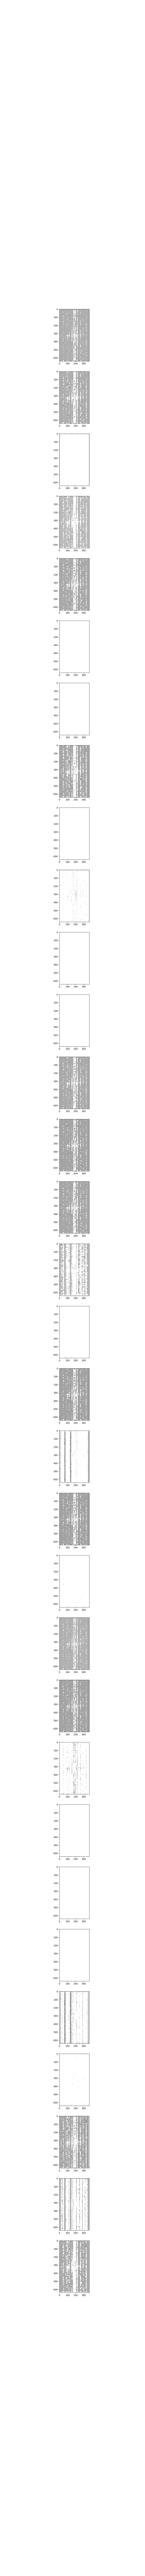

/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [15]:
unique_non_nuls = np.unique(np.where(res[0] != 0)[2])
n_non_nuls = len(unique_non_nuls)
print(n_non_nuls)
fig, axs = plt.subplots(n_non_nuls, figsize=(9, 5*n_non_nuls))
for i, ax in zip(unique_non_nuls, axs):
    ax.imshow(np.log(np.squeeze(res[0, ..., i])))
#     ax.imshow(np.squeeze(res[0, ..., i]))

<IPython.core.display.Javascript object>


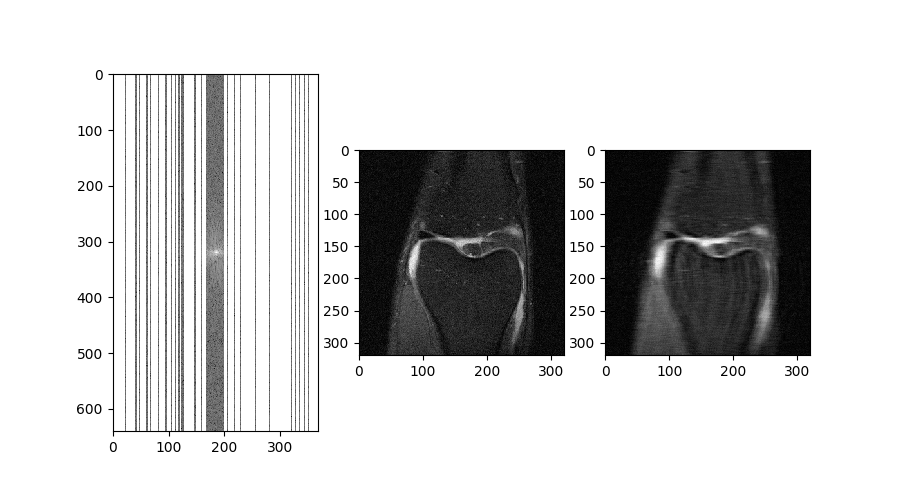

/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
fig, axs = plt.subplots(1, 3)
# axs[0].imshow(np.squeeze(np.abs(data[0][0])))
axs[0].imshow(np.squeeze(np.log(np.abs(train_gen[i_train][0][0]))))
axs[1].imshow(np.squeeze(np.abs(data[1])))
axs[2].imshow(np.squeeze(np.abs(model.predict_on_batch(data[0]))))

In [19]:
%%time
model.predict_on_batch(data[0])

CPU times: user 106 ms, sys: 35.2 ms, total: 141 ms
Wall time: 251 ms


array([[[[ 2.5105863],
         [ 2.2844186],
         [ 2.9255068],
         ...,
         [ 5.974179 ],
         [ 8.39277  ],
         [ 4.989845 ]],

        [[10.523205 ],
         [ 7.7990017],
         [ 8.268848 ],
         ...,
         [ 6.798434 ],
         [ 5.387763 ],
         [ 1.6434573]],

        [[ 8.238167 ],
         [ 4.740513 ],
         [ 1.1490599],
         ...,
         [ 4.329917 ],
         [ 4.540063 ],
         [ 2.5621715]],

        ...,

        [[ 2.629442 ],
         [ 8.001785 ],
         [ 5.8727417],
         ...,
         [ 6.1372867],
         [ 7.473578 ],
         [12.923987 ]],

        [[ 3.38807  ],
         [ 3.1575053],
         [ 0.6948973],
         ...,
         [ 1.6436739],
         [ 2.9854734],
         [10.388833 ]],

        [[ 4.3943744],
         [ 1.4688668],
         [ 2.6390533],
         ...,
         [ 5.9300327],
         [ 2.3564692],
         [ 5.5706224]]]], dtype=float32)